<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/reverse_eng_fg_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# font stuff for stream

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

<IPython.core.display.Javascript object>

# Stuff model walkthrough  
https://github.com/saberpowers/talks/blob/master/2023/saberseminar/slides.pdf  

https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/   


# getting stuff+ from fangraphs and reverse engineering it



In [ ]:
!pip install pybaseball
!pip install catboost

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 13.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pybaseball as bb

import catboost as cb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, percentileofscore
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  """
  draw strike zone
  draw the strike zone on a plot using mpl
  inputs:
    sz_top: top of strike zone (ft)
    sz_bot: bottom of strike zone (ft)
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    strike zone plot
  """
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls)

def draw_home_plate(catcher_perspective=True, ls='k-'):
  """
  draw home plate from either the catcher perspective or pitcher perspective
  inputs:
    catcher_perspective: orient home plate in the catcher POV. if False, orients
      home plate in the pitcher POV.
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    home plate plot
  """
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
project_dir = 'drive/My Drive/fg-stuff-rev-eng'
df_stuff = pd.read_csv(f'{project_dir}/df_stuff.csv')
df_stuff.shape

<IPython.core.display.Javascript object>

In [ ]:
df = pd.DataFrame()
df = pd.read_csv(f'{project_dir}/df.csv')
df.loc[df['description'].isin(['foul', 'swinging_strike','hit_into_play', 'foul_tip','swinging_strike_blocked']), 'swing'] = 1
df['p_team'] = df['away_team']
df.loc[(df['inning_topbot']=='Top'), 'p_team'] = df.loc[(df['inning_topbot']=='Top'), 'home_team']
df['year'] = pd.to_datetime(df['game_date']).dt.year
df = df.reset_index(drop=True)
for col in ['pfx_x', 'release_pos_x']:
  df.loc[df['p_throws']=='L', col] = df.loc[df['p_throws']=='L', col].mul(-1)

df['pitch_family'] = 'Other'
df.loc[df['pitch_type'].isin(['FF','SI']), 'pitch_family'] = 'Fastball'
df.loc[df['pitch_type'].isin(['SL','ST','FC','SV']), 'pitch_family'] = 'Slider'
df.loc[df['pitch_type'].isin(['CU','CS','KC']), 'pitch_family'] = 'Curveball'
df.loc[df['pitch_type'].isin(['CH','FS','KN','SC','FO']), 'pitch_family'] = 'Offspeed'
df['pitch_family_code'] = df['pitch_family'].astype('category').cat.codes
_df = df.loc[df['pitch_family']=='Fastball', ['year','pitcher','release_speed','pfx_x','pfx_z']].groupby(['year','pitcher'],as_index=False).mean().rename(columns={'release_speed':'release_speed_avg','pfx_x':'pfx_x_avg','pfx_z':'pfx_z_avg'})
df = df.merge(_df)
for col in ['release_speed','pfx_x','pfx_z']:
  df[f"{col}_diff"] = df[col].sub(df[f"{col}_avg"])
df.shape

<IPython.core.display.Javascript object>

(2280301, 106)

In [ ]:
feats = ['release_spin_rate','spin_axis']
targets = ['pfx_x', 'pfx_z']
folds = 3
kf = KFold(folds, shuffle=True)
s = {}
s['pfx_x'] = pd.Series()
s['pfx_z'] = pd.Series()

model_data = df.dropna(subset=feats+targets)
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]

  for target in targets:
    model = cb.CatBoostRegressor(iterations=300,verbose=False)
    model.fit(train.loc[:, feats], train[target])
    _s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
    s[target] = pd.concat([s[target], _s])

model_data['pfx_x_pred'] = s['pfx_x']
model_data['pfx_z_pred'] = s['pfx_z']
model_data['ssw_x'] = model_data['pfx_x'].sub(model_data['pfx_x_pred'])
model_data['ssw_z'] = model_data['pfx_z'].sub(model_data['pfx_z_pred'])
df['ssw_x'] = model_data['ssw_x']
df['ssw_z'] = model_data['ssw_z']

<IPython.core.display.Javascript object>

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-8-3b009846b22e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['pfx_x_pred'] = s['pfx_x']
<ipython-input-8-3b009846b22e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['pfx_z_pred'] = s['pfx_z']
<ipython-input-8-3b009846b22e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [ ]:
df.shape

<IPython.core.display.Javascript object>

(2280301, 108)

<IPython.core.display.Javascript object>

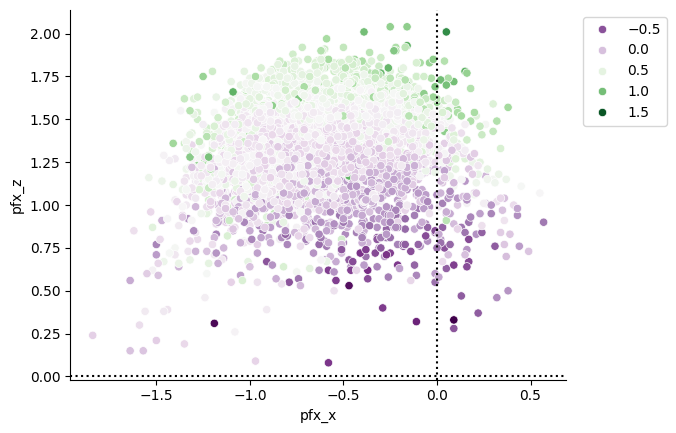

In [ ]:
sns.scatterplot(data=df.loc[(df['pitch_name']=='4-Seam Fastball')].sample(5000),
                x='pfx_x', y='pfx_z', hue='ssw_z', palette='PRGn')
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

0.005    72.2
0.995    99.8
Name: release_speed, dtype: float64

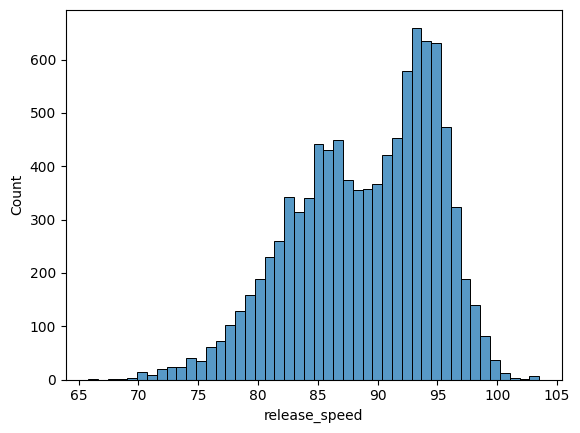

In [ ]:
sns.histplot(df['release_speed'].sample(10000))
df['release_speed'].quantile([.005,.995])

<IPython.core.display.Javascript object>

0.005   -1.68
0.995    1.66
Name: pfx_x, dtype: float64

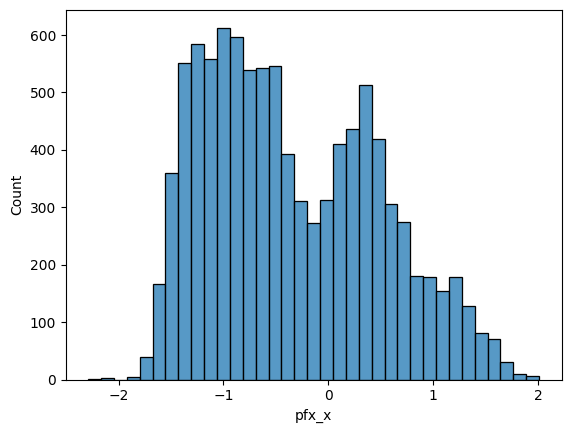

In [ ]:
sns.histplot(df['pfx_x'].sample(10000))
df['pfx_x'].quantile([.005,.995])

<IPython.core.display.Javascript object>

0.005   -1.45
0.995    1.79
Name: pfx_z, dtype: float64

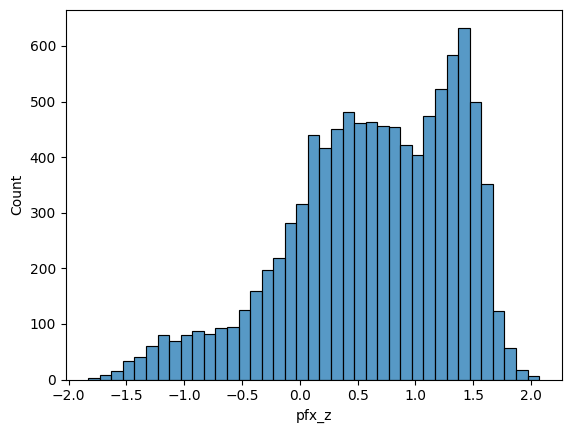

In [ ]:
sns.histplot(df['pfx_z'].sample(10000))
df['pfx_z'].quantile([.005,.995])

<IPython.core.display.Javascript object>

0.005   -2.13
0.995    2.24
Name: plate_x, dtype: float64

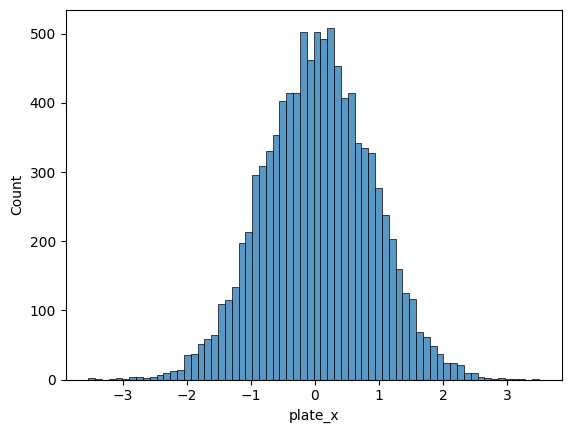

In [ ]:
sns.histplot(df['plate_x'].sample(10000))
df['plate_x'].quantile([.005,.995])

In [ ]:
id_feats = ['year','pitcher', 'pitcher_name', 'pitch_type','pitch_name']
feats = ['release_speed', 'pfx_x','pfx_z','release_pos_x','release_pos_z',
         'release_extension', 'release_speed_diff',
         'pfx_x_diff','pfx_z_diff','release_spin_rate', 'spin_axis',
         'ssw_x', 'ssw_z']
target = 'delta_run_exp'
model_data = df.loc[(df['release_speed']>70) & (df['pfx_x'].between(-2,2)) & (df['pfx_z'].between(-2,2)) & (df['plate_x'].between(-1.667,1.667))].dropna(subset=id_feats+feats+[target])
model_data.shape

<IPython.core.display.Javascript object>

(2038940, 108)

## Stuff model

In [ ]:
folds = 3
kf = KFold(folds, shuffle=True)
s = pd.Series()
for pt in tqdm(model_data['pitch_family'].unique()):
  _model_data = model_data.loc[model_data['pitch_family']==pt].copy()
  for train_idx, test_idx in tqdm(kf.split(_model_data), total=folds, leave=False):
    train = _model_data.iloc[train_idx]
    test = _model_data.iloc[test_idx]

    model = cb.CatBoostRegressor(iterations=300,verbose=False)
    model.fit(train.loc[:, feats], train[target])
    _s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
    s = pd.concat([s, _s])

model_data['xrv'] = s

<IPython.core.display.Javascript object>

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Location model

adds `plate_x` and `plate_z` to the stuff feature set and then subtracts the stuff xrv outputs to get location

In [ ]:
id_feats = ['year','pitcher', 'pitcher_name', 'pitch_type','pitch_name']
feats = ['release_speed', 'pfx_x','pfx_z','release_pos_x','release_pos_z',
         'release_extension', 'release_speed_diff',
         'pfx_x_diff','pfx_z_diff','release_spin_rate', 'spin_axis',
         'ssw_x', 'ssw_z', 'balls', 'strikes','plate_x','plate_z']
target = 'delta_run_exp'

folds = 3
kf = KFold(folds, shuffle=True)
s = pd.Series()
for pt in tqdm(model_data['pitch_family'].unique()):
  _model_data = model_data.loc[model_data['pitch_family']==pt].copy()
  for train_idx, test_idx in tqdm(kf.split(_model_data), total=folds, leave=False):
    train = _model_data.iloc[train_idx]
    test = _model_data.iloc[test_idx]

    model = cb.CatBoostRegressor(iterations=300,verbose=False)
    model.fit(train.loc[:, feats], train[target])
    _s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
    s = pd.concat([s, _s])

model_data['xrv2'] = s.sub(model_data['xrv'])

<IPython.core.display.Javascript object>

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
for fam in model_data['pitch_family'].unique():
  max = round(abs(model_data.loc[model_data['pitch_family']==fam, 'xrv'].max()), 3)+0.001
  _s = model_data.loc[model_data['pitch_family']==fam, 'xrv'].sub(max).mul(-1)
  _s = round(100*(_s/_s.mean()))
  model_data[f'Stuff+ {fam}'] = _s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

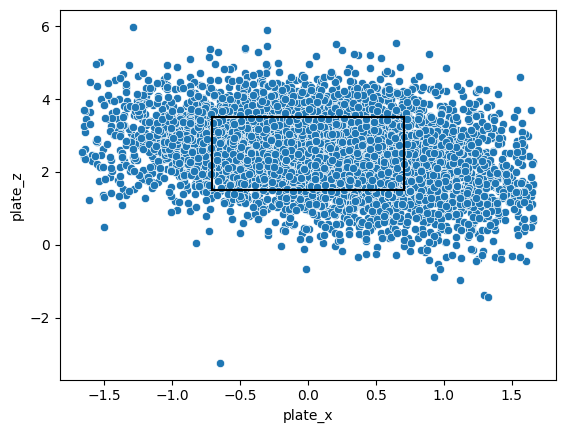

In [ ]:
sns.scatterplot(data=model_data.loc[model_data['pitcher']==434378], x='plate_x', y='plate_z')
draw_sz()
plt.show()

In [ ]:
_gauss = model_data.loc[:, ['pitcher','plate_x', 'plate_z','xrv2']].copy()
_gauss = _gauss.groupby(['pitcher','plate_x', 'plate_z'], as_index=False).count().rename(columns={'xrv2':'count'})
# _gauss['count'].value_counts()
_gauss.loc[_gauss['pitcher']==434378,'count'].value_counts()

<IPython.core.display.Javascript object>

count
1    5041
2     187
3       3
Name: count, dtype: int64

In [ ]:
from scipy.ndimage import gaussian_filter

<IPython.core.display.Javascript object>

In [ ]:
_gauss.head()

<IPython.core.display.Javascript object>

,pitcher,plate_x,plate_z,count
0,424144,-1.41,1.59,1
1,424144,-1.32,1.95,1
2,424144,-1.18,0.23,1
3,424144,-1.15,1.06,1
4,424144,-1.14,3.17,1


In [ ]:
118.1-69

<IPython.core.display.Javascript object>

49.099999999999994

<IPython.core.display.Javascript object>

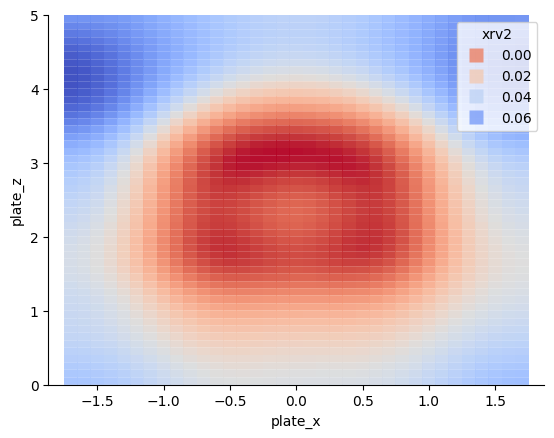

In [ ]:
_gauss = model_data.loc[:, ['plate_x', 'plate_z','xrv2']].copy()
_gauss.loc[:, ['plate_x', 'plate_z']] = _gauss.loc[:, ['plate_x', 'plate_z']].round(1)
# _gauss.head()
_gauss = _gauss.groupby(['plate_x', 'plate_z'], as_index=False).mean()
_gauss = pd.pivot_table(_gauss, index='plate_z', columns='plate_x').fillna(0)
_gauss = pd.DataFrame(gaussian_filter(_gauss, sigma=3), index=_gauss.index, columns=_gauss.columns)
_gauss = _gauss.reset_index()
_gauss = pd.melt(_gauss, id_vars=['plate_z']).rename(columns={'value':'xrv2'})
# sns.heatmap(_gauss)
sns.scatterplot(data=_gauss, x='plate_x', y='plate_z', hue='xrv2', palette='coolwarm_r',
                s=100,marker='s', alpha=.8, edgecolor='none')
plt.ylim(0,5)
sns.despine()
plt.show()

In [ ]:
model_data['New Loc+'] = (model_data['xrv2'].mul(-2271.00232862)).add(95.95332648700114)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

count    2038940.000
mean          -0.003
std            0.019
min           -0.335
25%           -0.012
50%           -0.003
75%            0.005
max            1.081
Name: xrv, dtype: float64

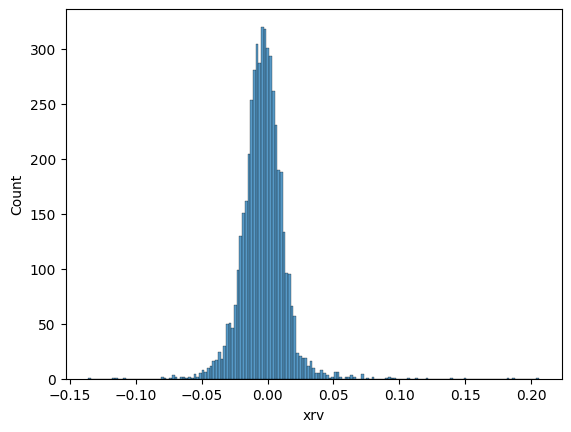

In [ ]:
sns.histplot(model_data['xrv'].sample(5000))
model_data['xrv'].describe().round(3)

In [ ]:
_df = model_data.loc[:, ['year','pitcher_name', 'pitcher', 'pitch_family', 'xrv', 'xrv2', 'New Loc+']].groupby(['year','pitcher_name', 'pitcher', 'pitch_family'], as_index=False).mean()
# _df = _df.loc[:, ['year','pitcher_name', 'pitcher', 'pitch_family', 'xrv']].groupby(['year','pitcher_name', 'pitcher', 'pitch_family'], as_index=False).mean()
for fam in _df['pitch_family'].unique():
  max = round(abs(_df.loc[_df['pitch_family']==fam, 'xrv'].max()), 3)+0.001
  _s = _df.loc[_df['pitch_family']==fam, 'xrv'].sub(max).mul(-1)
  _s = round(100*(_s/_s.mean()))
  _df[f'Stuff+ {fam}'] = _s

  max = round(abs(_df.loc[_df['pitch_family']==fam, 'xrv2'].max()), 3)+0.001
  _s = _df.loc[_df['pitch_family']==fam, 'xrv2'].sub(max).mul(-1)
  _s = round(100*(_s/_s.mean()))
  _df[f'Loc+ {fam}'] = _s

# max = round(abs(_df.loc[:, 'xrv'].max()), 3)+0.001
# _s = _df.loc[:, 'xrv'].sub(max).mul(-1)
# _s = round(100*(_s/_s.mean()))
# _df[f'New Stuff+'] = _s

new_stuff = _df.copy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

count    8112.000
mean       -0.001
std         0.013
min        -0.070
25%        -0.006
50%        -0.001
75%         0.003
max         0.544
Name: xrv, dtype: float64

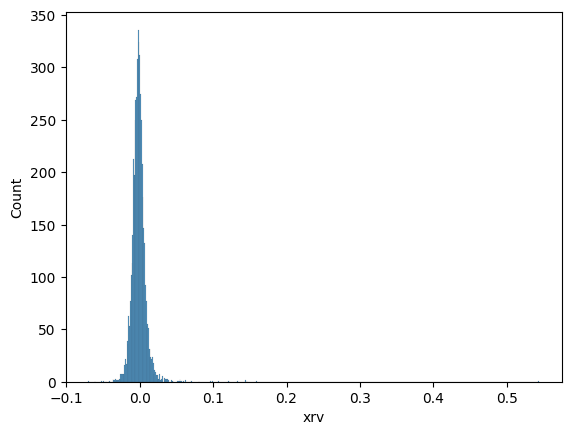

In [ ]:
sns.histplot(_df['xrv'].sample(5000))
_df['xrv'].describe().round(3)

In [ ]:
new_stuff.head()

<IPython.core.display.Javascript object>

,year,pitcher_name,pitcher,pitch_family,xrv,xrv2,New Loc+,Stuff+ Curveball,Loc+ Curveball,Stuff+ Fastball,Loc+ Fastball,Stuff+ Offspeed,Loc+ Offspeed,Stuff+ Slider,Loc+ Slider,Stuff+ Other,Loc+ Other
0,2021,"Abad, Fernando",472551,Curveball,-0.000455,-0.003619,104.172339,101.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,"Abad, Fernando",472551,Fastball,0.001338,-0.000985,98.191104,NaN,NaN,98.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,"Abad, Fernando",472551,Offspeed,0.020997,-0.001794,100.027694,NaN,NaN,NaN,NaN,94.0,101.0,NaN,NaN,NaN,NaN
3,2021,"Abad, Fernando",472551,Slider,-0.000765,-0.004638,106.486001,NaN,NaN,NaN,NaN,NaN,NaN,99.0,103.0,NaN,NaN
4,2021,"Abbott, Cory",676265,Curveball,-0.012599,0.004648,85.398338,110.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

count    8112.000000
mean       -0.000798
std         0.013150
min        -0.069959
25%        -0.006082
50%        -0.001480
75%         0.003142
max         0.543887
Name: xrv, dtype: float64

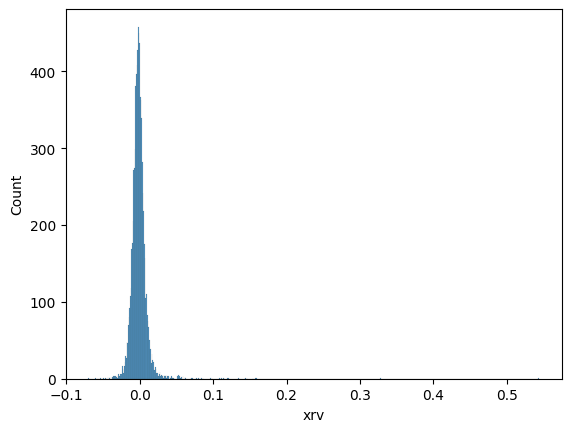

In [ ]:
sns.histplot(new_stuff['xrv'])
new_stuff['xrv'].describe()

<IPython.core.display.Javascript object>

count    2459.000000
mean       99.997967
std         4.124634
min         1.000000
25%        98.000000
50%       100.000000
75%       102.000000
max       118.000000
Name: Stuff+ Fastball, dtype: float64

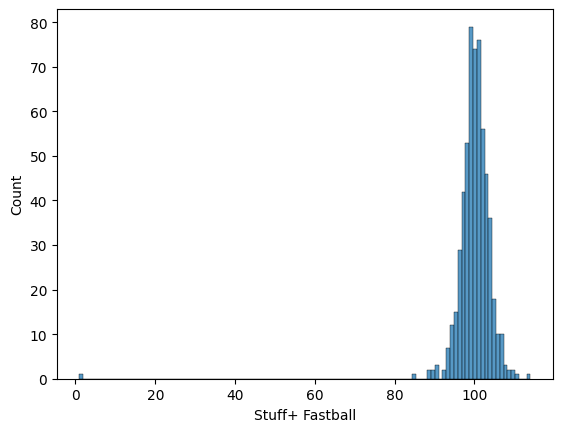

In [ ]:
col = 'Stuff+ Fastball'
sns.histplot(new_stuff[col].sample(2000))
new_stuff[col].describe()

In [ ]:
model_data.loc[:, [target, 'xrv']].describe().round(3)

<IPython.core.display.Javascript object>

,delta_run_exp,xrv
count,2038940.000,2038940.000
mean,-0.003,-0.003
std,0.246,0.019
min,-1.538,-0.335
25%,-0.070,-0.012
50%,-0.023,-0.003
75%,0.034,0.005
max,3.653,1.081


<IPython.core.display.Javascript object>

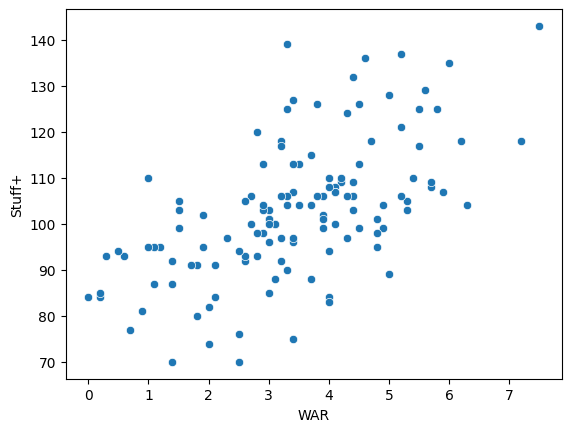

In [ ]:
sns.scatterplot(data=df_stuff, x='WAR', y='Stuff+')
plt.show()

In [ ]:
pids = df_stuff['IDfg'].unique().tolist()
pids = bb.playerid_reverse_lookup(player_ids=pids,key_type='fangraphs')
pids = pids.loc[:,['key_mlbam','key_fangraphs']].rename(columns={'key_mlbam':'pitcher', 'key_fangraphs':'IDfg'})
df_stuff = pids.merge(df_stuff)

<IPython.core.display.Javascript object>

Gathering player lookup table. This may take a moment.


In [ ]:
new_stuff.head()

<IPython.core.display.Javascript object>

,year,pitcher_name,pitcher,pitch_family,xrv,xrv2,New Loc+,Stuff+ Curveball,Loc+ Curveball,Stuff+ Fastball,Loc+ Fastball,Stuff+ Offspeed,Loc+ Offspeed,Stuff+ Slider,Loc+ Slider,Stuff+ Other,Loc+ Other
0,2021,"Abad, Fernando",472551,Curveball,-0.000455,-0.003619,104.172339,101.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,"Abad, Fernando",472551,Fastball,0.001338,-0.000985,98.191104,NaN,NaN,98.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,"Abad, Fernando",472551,Offspeed,0.020997,-0.001794,100.027694,NaN,NaN,NaN,NaN,94.0,101.0,NaN,NaN,NaN,NaN
3,2021,"Abad, Fernando",472551,Slider,-0.000765,-0.004638,106.486001,NaN,NaN,NaN,NaN,NaN,NaN,99.0,103.0,NaN,NaN
4,2021,"Abbott, Cory",676265,Curveball,-0.012599,0.004648,85.398338,110.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cols = ['year','pitcher_name', 'pitcher',
    'Stuff+ Fastball', 'Stuff+ Slider', 'Stuff+ Curveball',
       'Stuff+ Offspeed', 'Stuff+ Other', 'xrv','xrv2', 'New Loc+'
]

# cols = ['year','pitcher_name', 'pitcher','New Stuff+'
# ]

_df = new_stuff.loc[:, cols].groupby(['year','pitcher_name', 'pitcher'],as_index=False).mean()
cols = ['pitcher', 'IDfg', 'Season',
        'Stf+ CH','Stf+ CU', 'Stf+ FA',
        'Stf+ SI', 'Stf+ SL','Stf+ KC',
        'Stf+ FC', 'Stf+ FS', 'Stuff+',
        'Loc+ CH','Loc+ CU', 'Loc+ FA',
        'Loc+ SI', 'Loc+ SL','Loc+ KC',
        'Loc+ FC', 'Loc+ FS', 'Location+'
]
_df2 = df_stuff.loc[:, cols].rename(columns={'Season':'year'})
df_corr = _df.merge(_df2)

<IPython.core.display.Javascript object>

In [ ]:
df_corr.columns.values

<IPython.core.display.Javascript object>

array(['year', 'pitcher_name', 'pitcher', 'Stuff+ Fastball',
       'Stuff+ Slider', 'Stuff+ Curveball', 'Stuff+ Offspeed',
       'Stuff+ Other', 'xrv', 'xrv2', 'New Loc+', 'IDfg', 'Stf+ CH',
       'Stf+ CU', 'Stf+ FA', 'Stf+ SI', 'Stf+ SL', 'Stf+ KC', 'Stf+ FC',
       'Stf+ FS', 'Stuff+', 'Loc+ CH', 'Loc+ CU', 'Loc+ FA', 'Loc+ SI',
       'Loc+ SL', 'Loc+ KC', 'Loc+ FC', 'Loc+ FS', 'Location+'],
      dtype=object)

In [ ]:
model = LinearRegression()
model.fit(df_corr.loc[:, ['xrv2']], df_corr['Location+'])

<IPython.core.display.Javascript object>

LinearRegression()

In [ ]:
_df = df.loc[:, ['year','pitcher', 'game_pk', 'pitch_number']].groupby(['year','game_pk','pitcher'], as_index=False).count()
_df = _df.loc[:, ['year','pitcher', 'pitch_number']].groupby(['year','pitcher'], as_index=False).mean()
pitchers = _df.loc[_df['pitch_number']>85,'pitcher'].unique()

_df = df.loc[df['pitcher'].isin(pitchers), ['year','pitcher', 'pitch_number']].groupby(['year','pitcher'], as_index=False).count()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

count     348.000000
mean     2168.577586
std       955.714943
min        26.000000
25%      1561.250000
50%      2406.500000
75%      2952.500000
max      3695.000000
Name: pitch_number, dtype: float64

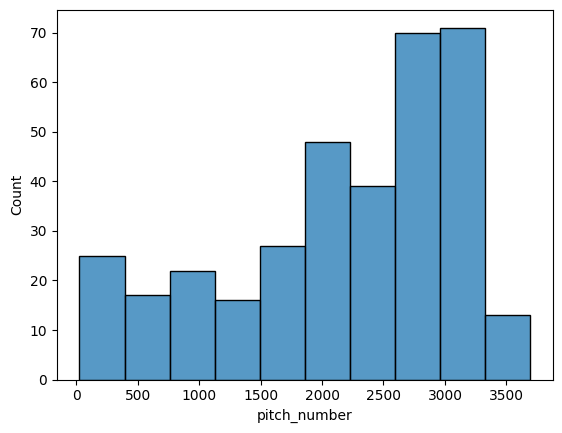

In [ ]:
sns.histplot(_df.loc[:,'pitch_number'])
_df.loc[:,'pitch_number'].describe()

In [ ]:
model.coef_, model.intercept_

<IPython.core.display.Javascript object>

(array([-672.91184719]), 102.06125326170603)

In [ ]:
model_data['New Stuff+'] = (model_data['xrv'].mul(-2271.00232862)).add(95.95332648700114)
df_corr['New Stuff+'] = (df_corr['xrv'].mul(-2271.00232862)).add(95.95332648700114)

model_data['Newer Loc+'] = (model_data['xrv2'].mul(-865.37897208)).add(102.08931442234268)
df_corr['Newer Loc+'] = (df_corr['xrv2'].mul(-865.37897208)).add(102.08931442234268)

<IPython.core.display.Javascript object>

In [ ]:
df_corr.head()

<IPython.core.display.Javascript object>

,year,pitcher_name,pitcher,Stuff+ Fastball,Stuff+ Slider,Stuff+ Curveball,Stuff+ Offspeed,Stuff+ Other,xrv,xrv2,...,Loc+ CU,Loc+ FA,Loc+ SI,Loc+ SL,Loc+ KC,Loc+ FC,Loc+ FS,Location+,New Stuff+,Newer Loc+
0,2021,"Alcantara, Sandy",645261,104.0,100.0,102.0,105.0,NaN,-0.007400,0.000133,...,93.0,107.0,103.0,107.0,NaN,NaN,NaN,105,112.759548,101.973801
1,2021,"Anderson, Tyler",542881,100.0,99.0,93.0,100.0,NaN,0.002655,-0.001571,...,109.0,107.0,109.0,NaN,NaN,107.0,NaN,107,89.924748,103.448796
2,2021,"Berríos, José",621244,103.0,101.0,NaN,100.0,NaN,-0.003509,0.001122,...,106.0,102.0,102.0,NaN,NaN,NaN,NaN,103,103.923339,101.118248
3,2021,"Buehler, Walker",621111,103.0,102.0,100.0,100.0,NaN,-0.004546,-0.002123,...,NaN,103.0,100.0,113.0,100.0,103.0,NaN,104,106.278127,103.926698
4,2021,"Burnes, Corbin",669203,98.0,103.0,113.0,102.0,NaN,-0.009073,-0.001231,...,103.0,111.0,109.0,105.0,NaN,105.0,NaN,104,116.557009,103.154227


<IPython.core.display.Javascript object>

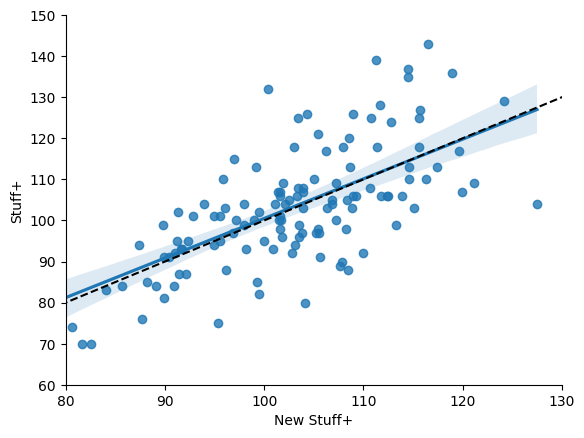

In [ ]:
x = 'New Stuff+'
y = 'Stuff+'
sns.regplot(data=df_corr, x=x, y=y)
plt.plot([0,200],[0,200],'k--')
plt.xlim(80,130)
plt.ylim(60,150)
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

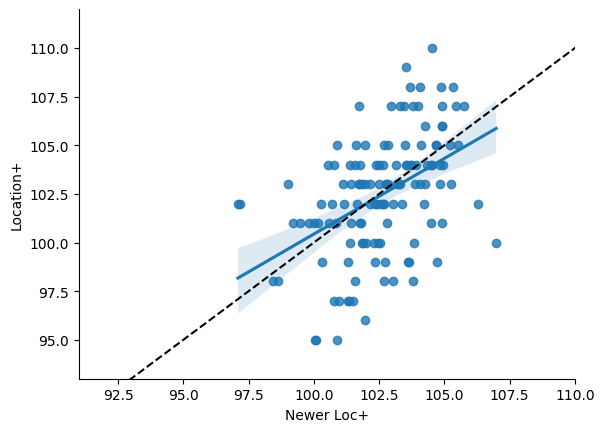

In [ ]:
x = 'Newer Loc+'
y = 'Location+'
sns.regplot(data=df_corr, x=x, y=y)
plt.plot([0,200],[0,200],'k--')
plt.xlim(91,110)
plt.ylim(93,112)
sns.despine()
plt.show()

In [ ]:
new_stuff.head()

<IPython.core.display.Javascript object>

,year,pitcher_name,pitcher,pitch_family,xrv,xrv2,New Loc+,Stuff+ Curveball,Loc+ Curveball,Stuff+ Fastball,Loc+ Fastball,Stuff+ Offspeed,Loc+ Offspeed,Stuff+ Slider,Loc+ Slider,Stuff+ Other,Loc+ Other
0,2021,"Abad, Fernando",472551,Curveball,-0.000455,-0.003619,104.172339,101.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,"Abad, Fernando",472551,Fastball,0.001338,-0.000985,98.191104,NaN,NaN,98.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,"Abad, Fernando",472551,Offspeed,0.020997,-0.001794,100.027694,NaN,NaN,NaN,NaN,94.0,101.0,NaN,NaN,NaN,NaN
3,2021,"Abad, Fernando",472551,Slider,-0.000765,-0.004638,106.486001,NaN,NaN,NaN,NaN,NaN,NaN,99.0,103.0,NaN,NaN
4,2021,"Abbott, Cory",676265,Curveball,-0.012599,0.004648,85.398338,110.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
_df = model_data.loc[:, ['year','pitcher_name', 'pitcher', 'pitch_family', 'New Stuff+', 'xrv']].groupby(['year','pitcher_name', 'pitcher', 'pitch_family'], as_index=False).mean()
# _df = _df.loc[:, ['year','pitcher_name', 'pitcher', 'pitch_family', 'xrv']].groupby(['year','pitcher_name', 'pitcher', 'pitch_family'], as_index=False).mean()

for fam in _df['pitch_family'].unique():
  _df.loc[_df['pitch_family']==fam, f'Stuff+ {fam}'] = (_df.loc[_df['pitch_family']==fam, 'xrv'].mul(-2271.00232862)).add(95.95332648700114)
#   max = round(abs(_df.loc[_df['pitch_family']==fam, 'New Stuff+'].min()), 3)+0.001
#   _s = _df.loc[_df['pitch_family']==fam, 'New Stuff+'].add(max)
#   _s = round(100*(_s/_s.mean()))
#   _df[f'Stuff+ {fam}'] = _s

new_stuff = _df.copy()

cols = ['year','pitcher_name', 'pitcher',
    'Stuff+ Fastball', 'Stuff+ Slider', 'Stuff+ Curveball',
       'Stuff+ Offspeed', 'Stuff+ Other','New Stuff+', 'xrv'
]

# cols = ['year','pitcher_name', 'pitcher','New Stuff+'
# ]

_df = new_stuff.loc[:, cols].groupby(['year','pitcher_name', 'pitcher'],as_index=False).mean()
cols = ['pitcher', 'IDfg', 'Season',
    'Stf+ CH',
       'Stf+ CU', 'Stf+ FA',
       'Stf+ SI', 'Stf+ SL',
       'Stf+ KC', 'Stf+ FC',
       'Stf+ FS', 'Stuff+'
]
_df2 = df_stuff.loc[:, cols].rename(columns={'Season':'year'})
df_corr = _df.merge(_df2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

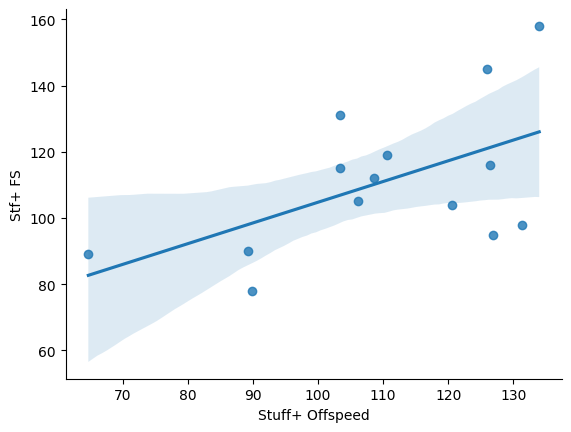

In [ ]:
x = 'Stuff+ Offspeed'
y = 'Stf+ FS'
sns.regplot(data=df_corr, x=x, y=y)
# plt.plot([0,200],[0,200],'k--')
# plt.xlim(70,130)
# plt.ylim(60,150)
sns.despine()
plt.show()

In [ ]:
model = LinearRegression()
model.fit(df_corr.loc[:, ['xrv']], df_corr['Stuff+'])
model.coef_, model.intercept_

<IPython.core.display.Javascript object>

(array([-2188.98051475]), 96.59405257057915)

In [ ]:
# model_data.loc[model_data['pitch_type'].isin(['KN','FS','CH'])].shape
model_data.loc[model_data['pitch_type'].isin(['KN'])].sample(20)

<IPython.core.display.Javascript object>

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher_name,batter,pitcher,events,description,...,xrv,xrv2,Stuff+ Fastball,Stuff+ Slider,Stuff+ Curveball,Stuff+ Offspeed,Stuff+ Other,New Loc+,New Stuff+,Newer Loc+
1956724,KN,2023-09-27,79.4,-1.55,5.39,"Waldron, Matt",592626,663362,NaN,ball,...,0.016369,0.003320,NaN,NaN,NaN,98.0,NaN,88.413845,58.779490,99.216350
734394,KN,2021-06-23,79.2,-1.42,5.91,"Jannis, Mickey",488726,595263,single,hit_into_play,...,0.028738,-0.032267,NaN,NaN,NaN,96.0,NaN,169.232647,30.688277,130.012836
1956971,KN,2023-09-10,72.7,-1.21,5.76,"Waldron, Matt",514888,663362,field_out,hit_into_play,...,0.041598,0.000912,NaN,NaN,NaN,94.0,NaN,93.882552,1.484799,101.300233
1956865,KN,2023-09-22,74.9,-1.50,5.44,"Waldron, Matt",502671,663362,NaN,foul,...,0.018473,-0.016867,NaN,NaN,NaN,97.0,NaN,134.257768,54.002235,116.685450
1956881,KN,2023-09-16,76.1,-1.58,5.50,"Waldron, Matt",676116,663362,NaN,ball,...,-0.050586,-0.014821,NaN,NaN,NaN,106.0,NaN,129.612868,210.833764,114.915483
1957222,KN,2023-08-19,79.7,-1.61,5.32,"Waldron, Matt",606466,663362,NaN,ball,...,0.040001,-0.148944,NaN,NaN,NaN,95.0,NaN,434.205156,5.110998,230.982190
1957152,KN,2023-08-31,77.3,-1.15,5.75,"Waldron, Matt",605204,663362,NaN,ball,...,-0.009701,0.054941,NaN,NaN,NaN,101.0,NaN,-28.817965,117.985365,54.544470
1957074,KN,2023-09-04,79.0,-1.64,5.42,"Waldron, Matt",547180,663362,NaN,foul,...,0.007892,-0.118622,NaN,NaN,NaN,99.0,NaN,365.343569,78.031613,204.742072
1956754,KN,2023-09-27,79.0,-1.27,5.51,"Waldron, Matt",682617,663362,NaN,swinging_strike,...,0.033734,-0.039614,NaN,NaN,NaN,95.0,NaN,185.916124,19.342352,136.370175
1956922,KN,2023-09-16,77.9,-1.72,5.64,"Waldron, Matt",691016,663362,NaN,ball,...,-0.002884,-0.082017,NaN,NaN,NaN,100.0,NaN,282.214727,102.502549,173.065331


In [ ]:
model_data['pitch_type'].unique()

<IPython.core.display.Javascript object>

array(['FF', 'SL', 'CU', 'CH', 'SI', 'FS', 'ST', 'FC', 'KC', 'FA', 'SV',
       'CS', 'PO', 'KN', 'SC', 'FO'], dtype=object)

In [ ]:
model_data.head()

<IPython.core.display.Javascript object>

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher_name,batter,pitcher,events,description,...,xrv,xrv2,Stuff+ Fastball,Stuff+ Slider,Stuff+ Curveball,Stuff+ Offspeed,Stuff+ Other,New Loc+,New Stuff+,Newer Loc+
0,FF,2021-11-02,93.7,-1.39,6.72,"Smith, Will",493329,519293,field_out,hit_into_play,...,0.010762,0.068930,99.0,NaN,NaN,NaN,NaN,-60.585812,71.512874,42.439143
1,FF,2021-11-02,92.9,-1.38,6.72,"Smith, Will",493329,519293,NaN,foul,...,0.010843,-0.002634,99.0,NaN,NaN,NaN,NaN,101.934392,71.329929,104.368435
2,FF,2021-11-02,93.1,-1.35,6.73,"Smith, Will",493329,519293,NaN,called_strike,...,0.002695,-0.024939,100.0,NaN,NaN,NaN,NaN,152.590881,89.832995,123.671392
3,FF,2021-11-02,94.6,-1.31,6.73,"Smith, Will",670541,519293,field_out,hit_into_play,...,0.003359,-0.008385,99.0,NaN,NaN,NaN,NaN,114.996591,88.324524,109.345864
4,FF,2021-11-02,93.6,-1.31,6.80,"Smith, Will",670541,519293,NaN,ball,...,0.004101,0.066326,99.0,NaN,NaN,NaN,NaN,-54.673840,86.640908,44.691935


<IPython.core.display.Javascript object>

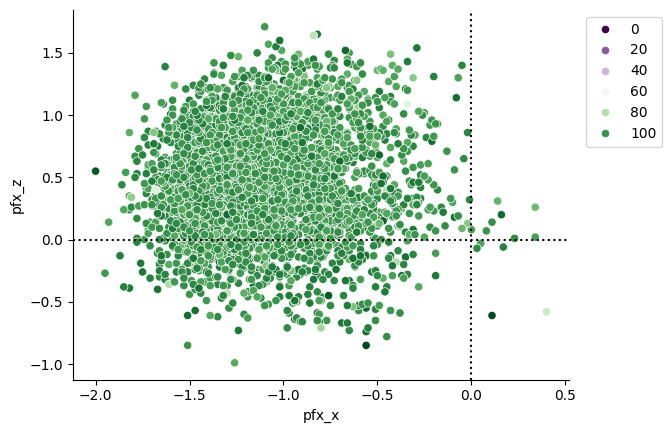

In [ ]:
fam = 'Offspeed'
sns.scatterplot(data=model_data.loc[model_data['pitch_family']==fam].sample(5000),
                x='pfx_x', y='pfx_z', hue=f'Stuff+ {fam}', palette='PRGn')
plt.axhline(0, c='k', ls=':')
plt.axvline(0, c='k', ls=':')
sns.despine()
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.show()

In [ ]:
model_data['pitch_family'].unique()

<IPython.core.display.Javascript object>

array(['Fastball', 'Slider', 'Curveball', 'Offspeed', 'Other'],
      dtype=object)

In [ ]:
fam = 'Slider'
df_agg = model_data.loc[:, id_feats+['pitch_family',f'New Stuff+']].groupby(id_feats+['pitch_family'], as_index=False).mean()
_df_agg = model_data.loc[:, id_feats+['pitch_family',f'New Stuff+']].groupby(id_feats+['pitch_family'], as_index=False).count().rename(columns={f'New Stuff+':'times_thrown'})
df_agg = df_agg.merge(_df_agg)
df_agg.loc[(df_agg['pitch_family']==fam) & (df_agg['times_thrown']>=30)].sort_values(f'New Stuff+', ascending=False).head(50)

<IPython.core.display.Javascript object>

,year,pitcher,pitcher_name,pitch_type,pitch_name,pitch_family,New Stuff+,times_thrown
9209,2023,666374,"Brash, Matt",SL,Slider,Slider,174.883853,582
1107,2021,594580,"Moll, Sam",ST,Sweeper,Slider,171.427260,61
10159,2023,689147,"Kerkering, Orion",ST,Sweeper,Slider,168.921522,49
1286,2021,605195,"Crick, Kyle",SL,Slider,Slider,165.861549,202
10018,2023,682842,"Uribe, Abner",SL,Slider,Slider,165.697181,143
2702,2021,661403,"Clase, Emmanuel",SL,Slider,Slider,165.664384,301
6146,2022,666374,"Brash, Matt",SL,Slider,Slider,164.287769,340
4798,2022,621242,"Díaz, Edwin",SL,Slider,Slider,162.622190,515
9028,2023,664126,"Fairbanks, Pete",SL,Slider,Slider,162.128673,364
6335,2022,669330,"Wells, Tyler",ST,Sweeper,Slider,161.605489,80


# Some notes on stuff  
The stuff model as reported on [Fangraphs](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/) (as well as location and pitching models) serve as a good starting point to build these models using statcast data. We use `pybaseball` to scrape the data over the last 3 full seasons to recreate their Stuff+ model. Our steps are the following:  

## Feature engineering

The following features are noted as essential in the development of stuff:  
1. Differences from average fastball velocity  
2. Differences from average fastball movement  
3. Seam-shifted wake induced movement  

I take some liberties with feature creation here. First, I cluster families of pitch types in order to work with less pitch types (for example, 2-seam and 4-seam fastball pitch types are simply both "fastball"). This allows for faster model creation at the expense of pitch type value accuracy. This also allows me to skirt around whether a pitcher primarily throws a 2-seam or a 4-seam fastball -- it is just fastball, regardless of fastball type. I use all fastballs to create the differences.

For seam-shifted wake, Fangraphs detailed they use spin information (this is both spin axis and spin rate data) to predict pitch movement (which is represented in the `pfx_x` and `pfx_z` columns from the statcast data). After predicting pitch movement via spin data, you can subtract `pfx_x` actual from `pfx_x` predicted to get seam-shifted wake in the X direction and the Z direction. Both of these should be features in the replication of the Fangraphs Stuff+ model.

Your results may vary by incorporating a pitch type feature into your model. My personal method for avoiding this is detailed in the methods section.  

Also, as Fangraphs mentions, their target feature is "run value" aka `delta_run_exp` from the statcast data -- which is the change in run expectancy from pre-pitch to post-pitch. This should represent a form of [RE288](http://tangotiger.com/index.php/site/comments/re288-run-expectancy-by-the-24-base-out-states-x-12-plate-count-states-recu), which is the expected run value by the end of the inning.  

## Modeling  
As Fangraphs describes, they use a tree-based model to predict run value per pitch given the "stuff" of a pitch. Most likely this is a flavor of gradient boosting (`xgboost`, `lightgbm`, `catboost`, etc). In my replication, I used `catboost`. It's `sklearn` flavored and typically is better than `xgboost` out of the box on [many baseball problem](https://www.kaggle.com/competitions/nwds-xstrikes/code).  

I chose not to tune the model for a variety of reasons, but mainly to save time in order to build this model within a couple days. As with other streams, I would strongly recommend tuning via `optuna` and leveraging `shap` for feature importance per pitch. An ensemble between `catboost` and `xgboost` that pools into something like an `h2O` neural net has always been a good recipe for accuracy (and perhaps hedging). These would be easy places to have big gains in my replication.  

I also chose to model each pitch family separately. This was for two reasons: 1. I didn't want other pitch types distorting the signal of why certain pitch types are valuable. For example, a 4-seam fastball is partially valued for its "rise" (aka the positive vertical break) while a curveball is partially valued for its "drop" (aka the negitive vertical break). Having both of these pitch types in a model train seems inefficient when trying to capture the value of break in these two different directions. From a use-case perspective, when analyzing a slider, I would compare a slider to other sliders (and not a random set of pitches which may contain sliders). You can avoid this either with more specific train-test folding or potentially through a pitch type feature. However, I do feel a lot better when a model contains only one group of pitch types because that is data bleed I can control (while the interactions within these pitch types are things I can't control).  

For folds, I chose 3 mainly out of time (I streamed all of this and didn't want chatters to be staring a `tqdm` as my content). More folds I believe would be better but I would perhaps suggest more _data_ being the better advantage over folds (I am only using 2021-2023 for this model).  

## Output processing  
The result of the model is the predicted `delta_run_exp` -- or expected run value aka `xrv`. This is a little funny since the original metric we are targeting is already called run expectancy. So in technicality, this is expected run expectancy -- which is why sports analytics communicated in the public is a god damn nightmare that even I reckon with on my stream to literal nerds who understand everything I'm talking about.  

It's important to understand how to go from `xrv` to "Stuff+". As Fangraphs also states (as does all of business analytics), a "plus" metric is simply dividing a prediction by the prediction average. Then, after multiplying by 100, you will have a scale where 100 is average and 110 would indicate 10% greater than average. While this seems to work, the distribution of the replicated Stuff+ values were very narrow (98-102, as opposed to 50-150). After some reverse engineering, it was easier to multiply `xrv` by the average number of pitches thrown by a starter and add ~100. Since `xrv` is centered at 0, and it is a value that represented a single pitch, it is logical to see that multiplying this value out by a full season of pitches and shifting the values to match a "plus" scale would return the equivalent of a true plus scale. While the math works, I do have some disagreements with "plus" scales in general. I think the world of analytics (and stuff/pitch models) would be better off converting metrics away from plus scales and towards percentile scales. At the end of the day, people conflate "more is better" in the stuff model world but it is always difficult to tell when 20% better (aka 120 Stuff+) is a meaningful increase. Percentiles would give context to the pool of pitches as well as giving a standard "middle ground" (45-55%tile).  

## Replication stats  
Correlation was very good. Very strong -- as one would expect, since it is exactly the same features and most likely the exact same data. The scaling of my Stuff+ to fit the Fangraphs distribution was slightly effortful, but relatively easy once I got my own head out of my ass trying to solve a linear problem with literally guessing. You can ask anyone in the discord "did he actually try to guess how this made and not just fit a linear model to the fangraphs outputs and extract the weights?". I literally spent the equivalent of a full stream guessing whether or not I missed a groupby or summed somewhere instead of averaging, or double aggregating over games and innings, or some other idiot andy bullshit. I really should of just taken `xrv` correlated it with the Fangraphs outputs and recognized the weights were a number I recognized (SP number of pitches in a season and shifting to literally 100).  


## Last thoughts
It is most likely advantageous to create a WAR representation of Stuff+. While Stuff+ is a good metric to contextualize what a pitcher is able to do, its use case in comparison to other metrics is still in need of research and promotion. There _is_ a correlation of Stuff+ to WAR, however there is no clear translation to go from Stuff+ _to_ WAR. Where WAR is helpful in overall value, Stuff+ WAR could be helpful in knowing what is valuing within a pitcher's arsenal or pitch type characteristics. For example, we know Spencer Strider throws one of the best fastballs in the league. How much of his WAR is due to his fastball? We could grossly say "a lot" and be pretty correct or we can do what we should do and showcase an actual pitch type WAR based on Stuff. And even deeper, what _components_ of his fastball is most valuable? Who in the industry has those _components_? Is it something someone can develop? Is it an innate talent? How valuable would improving a pitch be? These are all questions we can answer if we literally just fit Stuff to WAR and create a Stuff WAR metric. But I'm not gonna do it on this stream. Maybe a different stream. But someone should. But just not me. But someone out there really should.  

-nw 4/17/24